# Figure 4

Script to generate Figure 4 from [1]. This figure describes the distributed sensing method in the frequency domain.
- Using auxetic sensors (new with green wire)
- Initial length: 98 mm
- Date of data collection: 2023-01-30

> [1] Brett C. Hannigan, Tyler J. Cuthbert, Chakaveh Ahmadizadeh, and Carlo Menon. Distributed Sensing Along Fibres for Smart Clothing. *Science Advances*. 2023 (In Review).

©2023 ETH Zurich, Brett Hannigan; D-HEST; Biomedical and Mobile Health Technology (BMHT) Lab; Carlo Menon

In [2]:
library(scales)
library(ggplot2)
library(cowplot)
library(ggh4x)
library(dplyr)
library(broom)

## Import LCR Data

Files are named according to the format: `<sensor>_<strain>_<is_relaxation>`, where:
- `sensor` is one of A, B, C, D (from closest to readout port to furthers from readout port)
- `strain` is taken at levels of 0%, 10%, 20%, 30%, 40\%
- `is_relaxation` is FALSE for extension, TRUE for relaxation in preceeding step

In [3]:
RCparallel <- function(i, q, f) {
    i2q2 <- i^2+ q^2
    rp <- i2q2/i
    cp <- -1*q/(2*pi*f*i2q2)
    return(list(rp, cp))
}
RCseries <- function(i, q, f) {
    rs <- i
    cs <- -1/(2*pi*f*q)
    return(list(rs, cs))
}

In [9]:
PATH_PREFIX <- ".\\Data\\LCR"
REGEX_PATTERN <- "^([A-D])_([0-9]{2})_([0-9]{1}).csv$"
exc_freq <- c(99609.0, 49805.0, 24902.0, 12451.0)
files <- list.files(path=PATH_PREFIX, pattern=REGEX_PATTERN, no..=TRUE)
print(files)
lcr <- data.frame()
for (file in files) {
    d <- read.csv(file = file.path(PATH_PREFIX, file), header=FALSE, col.names=c("f", "Zmag", "Zphase", "", ""))
    head(d)
    parsed_filename <- regexec(REGEX_PATTERN, file)
    start <- unlist(parsed_filename)[2:4]
    end <- start + attr(parsed_filename[[1]], "match.length")[2:4] - 1
    I <- d$Zmag*cos(d$Zphase*pi/180.0)
    Q <- d$Zmag*sin(d$Zphase*pi/180.0)
    rpcp <- RCparallel(I, Q, d$f)
    rscs <- RCseries(I, Q, d$f)
    
    df <- data.frame(sensor = rep(substr(file, start[1], end[1]), nrow(d)),
                     strain = as.numeric(rep(substr(file, start[2], end[2]), nrow(d)))/100,
                     is.extension = !as.logical(as.numeric(rep(substr(file, start[3], end[3]), nrow(d)))),
                     f = d[1], 
                     I = I,
                     Q = Q,
                     Zmag = d[2],
                     Zphase = d[3],
                     Rp=rpcp[[1]],
                     Cp=rpcp[[2]],
                     Rs=rscs[[1]],
                     Cs=rscs[[2]])
    lcr <- rbind(lcr, df)
}
head(lcr)
save(lcr, file = file.path(PATH_PREFIX, "Data.Rda"))
#write.csv(lcr, file=file.path(PATH_PREFIX, "Data.csv"))

 [1] "A_00_0.csv" "A_00_1.csv" "A_10_0.csv" "A_10_1.csv" "A_20_0.csv"
 [6] "A_20_1.csv" "A_30_0.csv" "A_30_1.csv" "A_40_0.csv" "B_00_0.csv"
[11] "B_00_1.csv" "B_10_0.csv" "B_10_1.csv" "B_20_0.csv" "B_20_1.csv"
[16] "B_30_0.csv" "B_30_1.csv" "B_40_0.csv" "C_00_0.csv" "C_00_1.csv"
[21] "C_10_0.csv" "C_10_1.csv" "C_20_0.csv" "C_20_1.csv" "C_30_0.csv"
[26] "C_30_1.csv" "C_40_0.csv" "D_00_0.csv" "D_00_1.csv" "D_10_0.csv"
[31] "D_10_1.csv" "D_20_0.csv" "D_20_1.csv" "D_30_0.csv" "D_30_1.csv"
[36] "D_40_0.csv"


,sensor,strain,is.extension,f,I,Q,Zmag,Zphase,Rp,Cp,Rs,Cs
,<chr>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A,0,TRUE,1000.0,22473.58,-692037.2,692402,-88.140,21332624,2.297381e-10,22473.58,2.299803e-10
2,A,0,TRUE,1028.1,21835.52,-673839.3,674193,-88.144,20816363,2.294947e-10,21835.52,2.297357e-10
3,A,0,TRUE,1057.1,22087.48,-655121.8,655494,-88.069,19453211,2.295560e-10,22087.48,2.298169e-10
4,A,0,TRUE,1086.8,21943.82,-637318.3,637696,-88.028,18531696,2.295089e-10,21943.82,2.297810e-10
5,A,0,TRUE,1117.4,21848.28,-620375.4,620760,-87.983,17637221,2.293077e-10,21848.28,2.295921e-10
6,A,0,TRUE,1148.8,21553.42,-603321.1,603706,-87.954,16909657,2.293365e-10,21553.42,2.296292e-10


## Import Sensor Board Data

Files are named according to the format: `<sensor>_<strain>_<is_relaxation>`, where:
- `sensor` is one of A, B, C, D (from closest to readout port to furthers from readout port)
- `strain` is taken at levels of 0%, 10%, 20%, 30%, 40\%
- `is_relaxation` is FALSE for extension, TRUE for relaxation in preceeding step

In [10]:
avg_limit_low <- 100
avg_limit_high <- 400
PATH_PREFIX <- ".\\Data\\SensorBoard"
REGEX_PATTERN <- "^([A-D])_([0-9]{2})_([0-9]{1}).tsv$"
files <- list.files(path=PATH_PREFIX, pattern=REGEX_PATTERN, no..=TRUE, recursive=TRUE)
f <- c(99609.0, 49805.0, 24902.0, 12451.0)
sensor_board <- data.frame()
for (file in files) {
    print(file)
    d <- read.csv(file = file.path(PATH_PREFIX, file), sep = '\t', header=TRUE, col.names=c("t", "i0", "q0", "i1", "q1", "i2", "q2", "i3", "q3"))
    parsed_filename <- regexec(REGEX_PATTERN, file)
    start <- unlist(parsed_filename)[2:4]
    end <- start + attr(parsed_filename[[1]], "match.length")[2:4] - 1
    trial <- strtoi(substr(file, 4, 4))
    d$i0 <- d$i0*1.4253 -  82.30
    d$i1 <- d$i1*1.1516 - 125.95
    d$i2 <- d$i2*1.0519 - 108.39
    d$i3 <- d$i3*1.0344 - 110.18
    d$q0[d$i0<d$q0] <- d$q0[d$i0<d$q0]*6.1726 - 39098.0
    d$q0[d$i0>=d$q0] <- d$q0[d$i0>=d$q0]*2.0730 - 1068.5
    d$q1 <- d$q1*1.8172 - 2094.8
    d$q2 <- d$q2*1.2834 - 3640.2
    d$q3 <- d$q3*1.1780 - 1820.6
    I <- c(d$i0, d$i1, d$i2, d$i3)
    Q <- c(d$q0, d$q1, d$q2, d$q3)
    Zmag <- 2.0*sqrt(I^2 + Q^2)
    Zphase <- atan2(Q, I)*180/pi
    rpcp <- RCparallel(I, Q, rep(f, each=nrow(d)))
    rscs <- RCseries(I, Q, rep(f, each=nrow(d)))
    df <- data.frame(sensor=rep(substr(file, start[1], end[1]), length(f)*nrow(d)),
                     time=rep(d$t, length(f)),
                     strain = as.numeric(rep(substr(file, start[2], end[2]), nrow(d)))/100,
                     is.extension = !as.logical(as.numeric(rep(substr(file, start[3], end[3]), nrow(d)))),
                     f=rep(f, each=nrow(d)),
                     I=I,
                     Q=Q,
                     Zmag=Zmag,
                     Zphase=Zphase,
                     Rp=rpcp[[1]],
                     Cp=rpcp[[2]],
                     Rs=rscs[[1]],
                     Cs=rscs[[2]])
    sensor_board <- rbind(sensor_board, df)
}
head(sensor_board)
save(sensor_board, file=file.path(PATH_PREFIX, "Data.Rda"))
#write.csv(sensor_board, file=file.path(PATH_PREFIX, "Data.csv"))

[1] "A_00_0.tsv"
[1] "A_00_1.tsv"
[1] "A_10_0.tsv"
[1] "A_10_1.tsv"
[1] "A_20_0.tsv"
[1] "A_20_1.tsv"
[1] "A_30_0.tsv"
[1] "A_30_1.tsv"
[1] "A_40_0.tsv"
[1] "B_00_0.tsv"
[1] "B_00_1.tsv"
[1] "B_10_0.tsv"
[1] "B_10_1.tsv"
[1] "B_20_0.tsv"
[1] "B_20_1.tsv"
[1] "B_30_0.tsv"
[1] "B_30_1.tsv"
[1] "B_40_0.tsv"
[1] "C_00_0.tsv"
[1] "C_00_1.tsv"
[1] "C_10_0.tsv"
[1] "C_10_1.tsv"
[1] "C_20_0.tsv"
[1] "C_20_1.tsv"
[1] "C_30_0.tsv"
[1] "C_30_1.tsv"
[1] "C_40_0.tsv"
[1] "D_00_0.tsv"
[1] "D_00_1.tsv"
[1] "D_10_0.tsv"
[1] "D_10_1.tsv"
[1] "D_20_0.tsv"
[1] "D_20_1.tsv"
[1] "D_30_0.tsv"
[1] "D_30_1.tsv"
[1] "D_40_0.tsv"


,sensor,time,strain,is.extension,f,I,Q,Zmag,Zphase,Rp,Cp,Rs,Cs
,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A,0.000000,0,TRUE,99609,4325.640,-4956.536,13157.27,-48.88833,10005.09,1.829905e-10,4325.640,3.223616e-10
2,A,0.031606,0,TRUE,99609,4325.640,-4960.371,13163.05,-48.91028,10013.88,1.829713e-10,4325.640,3.221124e-10
3,A,0.079049,0,TRUE,99609,4325.640,-4960.371,13163.05,-48.91028,10013.88,1.829713e-10,4325.640,3.221124e-10
4,A,0.110633,0,TRUE,99609,4323.003,-4964.206,13165.36,-48.94952,10023.52,1.830483e-10,4323.003,3.218635e-10
5,A,0.157180,0,TRUE,99609,4325.640,-4964.206,13168.83,-48.93222,10022.68,1.829520e-10,4325.640,3.218635e-10
6,A,0.191272,0,TRUE,99609,4317.729,-4971.876,13170.02,-49.02795,10042.86,1.832016e-10,4317.729,3.213670e-10


In [11]:
sensor_board <- sensor_board %>%
    group_by(sensor, f, is.extension) %>%
        top_n(-25*20, time) %>%
            mutate(dCs=Cs-Cs[strain==0]) %>%
                mutate(dCp=Cp-Cp[strain==0]) %>%
                    group_by(sensor, strain, f, is.extension) %>%
                        summarise_at(vars(c("I", "Q", "Zmag", "Zphase", "Rp", "Cp", "Rs", "Cs", "dCs", "dCp")), list(mean=mean, sd=sd)) %>%
                            filter(is.extension) %>%
                                filter(strain!=0)
save(sensor_board, file=file.path(PATH_PREFIX, "DeltaCSensorBoardData.rdata"))

## Produce Figure from LCR Data

This is the 3rd column in the compiled figure. 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


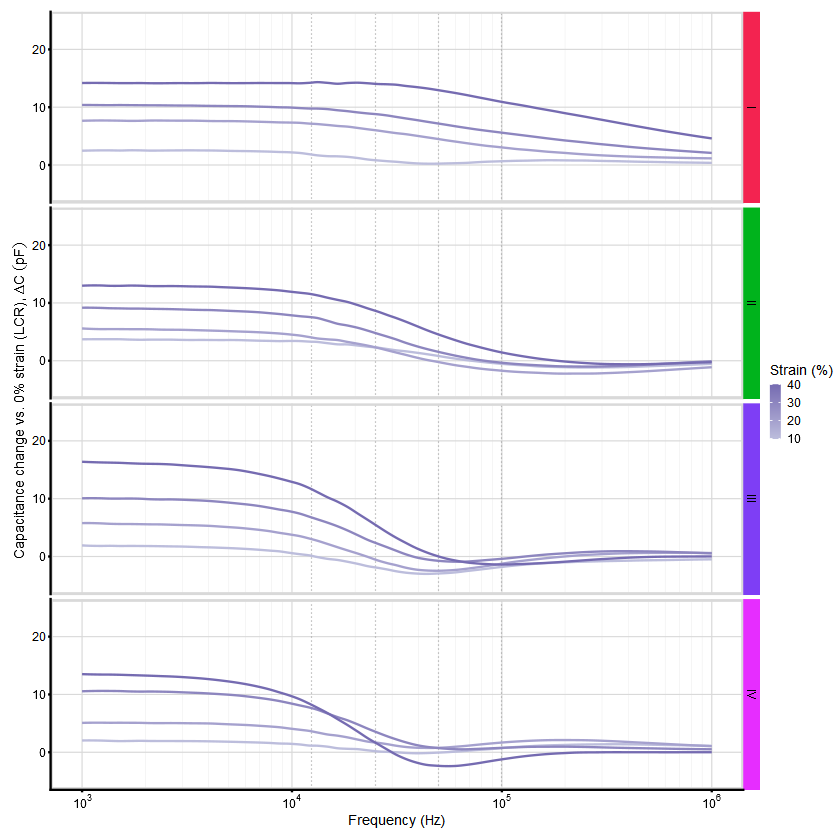

In [13]:
d <- subset(lcr, is.extension==TRUE)
d_0 <- subset(d, strain==0)
d$dRs <- d$Rs - rep(d_0$Rs, length(unique(d$strain)))
d$dCs <- d$Cs - rep(d_0$Cs, length(unique(d$strain)))
d$dRp <- d$Rp - rep(d_0$Rp, length(unique(d$strain)))
d$dCp <- d$Cp - rep(d_0$Cp, length(unique(d$strain)))

load("Data\\SensorBoard\\DeltaCSensorBoardData.rdata")

breaks <- 10^(3:6)
minor_breaks <- rep(1:9, length(breaks))*(10^rep((3:6), each=9))
strip <- strip_themed(background_y = elem_list_rect(fill = c('#F32350', '#00B31C', '#7E3EF5', '#E62DFF')))
# Change labels to roman numerals.
sensor_labeller <- as_labeller(c(
  'A'="I",
  'B'="II",
  'C'="III",
  'D'="IV"
))

plt2 <- ggplot(data=subset(d, strain!=0), aes(x=f, y=dCp*1e12, colour=strain, group=strain))
plt2 <- plt2 + geom_vline(aes(xintercept = exc_freq[1]),color="#969696", linewidth=0.25, linetype="dotted")
plt2 <- plt2 + geom_vline(aes(xintercept = exc_freq[2]),color="#969696", linewidth=0.25, linetype="dotted")
plt2 <- plt2 + geom_vline(aes(xintercept = exc_freq[3]),color="#969696", linewidth=0.25, linetype="dotted")
plt2 <- plt2 + geom_vline(aes(xintercept = exc_freq[4]),color="#969696", linewidth=0.25, linetype="dotted")
#plt2 <- plt2 + geom_point(data=sensor_board, aes(x=f, y=dCp_mean*1e12), size=0.75)
plt2 <- plt2 + scale_color_gradient(low='#bcbddc', high='#756bb1', labels=function(x)x*100, name="Strain (%)")
plt2 <- plt2 + geom_smooth(linewidth=0.5, n=250, span=0.08)
plt2 <- plt2 + scale_x_log10(breaks=breaks, minor_breaks=minor_breaks, labels=trans_format("log10", math_format(10^.x)))
plt2 <- plt2 + scale_y_continuous(minor_breaks=NULL, limits=c(-5,25), breaks=c(0, 10, 20))
plt2 <- plt2 + ylab(expression("Capacitance change vs. 0% strain (LCR),"~Delta*C~(pF)))
plt2 <- plt2 + xlab('Frequency (Hz)')
plt2 <- plt2 + facet_grid2(vars(sensor), strip=strip, labeller=sensor_labeller)
plt2 <- plt2 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt2 <- plt2 + panel_border() + background_grid(major="xy", minor="xy", size.major=0.25, size.minor=0.1)
plt2 <- plt2 + theme(panel.grid.minor = element_line(colour="#EBEBEB"))
plt2 <- plt2 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt2)
ggsave('DeltaCsLCR.png', width=50, height=50, units="mm", scale=1.5, dpi=600)
ggsave("DeltaCsLCR.eps", width=50, height=50, units="mm", scale=1.5, device=cairo_ps, fallback_resolution=600)

## Produce Figure from Simulation Data

Simulation data produced by the MATLAB script `ModelDistributedSensor.m`.

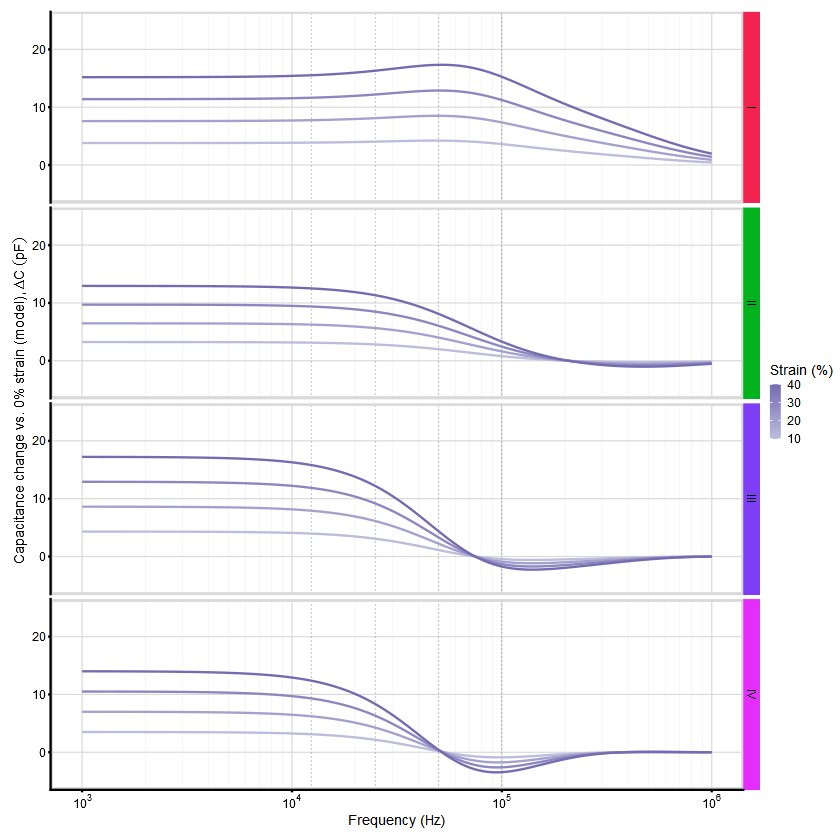

In [14]:
simulated <- read.csv(file = "Data\\Simulations\\DeltaCsSimulated_RCParallel.txt", header=TRUE)

plt3 <- ggplot(data=subset(simulated, strain!=0), aes(x=f, y=dCp*1e12, colour=strain, group=strain))
plt3 <- plt3 + geom_vline(aes(xintercept = exc_freq[1]),color="#969696", linewidth=0.25, linetype="dotted")
plt3 <- plt3 + geom_vline(aes(xintercept = exc_freq[2]),color="#969696", linewidth=0.25, linetype="dotted")
plt3 <- plt3 + geom_vline(aes(xintercept = exc_freq[3]),color="#969696", linewidth=0.25, linetype="dotted")
plt3 <- plt3 + geom_vline(aes(xintercept = exc_freq[4]),color="#969696", linewidth=0.25, linetype="dotted")
plt3 <- plt3 + scale_color_gradient(low='#bcbddc', high='#756bb1', labels=function(x)x*100, name="Strain (%)")
plt3 <- plt3 + geom_line(linewidth=0.5)
plt3 <- plt3 + scale_x_log10(breaks=breaks, minor_breaks=minor_breaks, labels=trans_format("log10", math_format(10^.x)))
plt3 <- plt3 + scale_y_continuous(minor_breaks=NULL, limits=c(-5,25), breaks=c(0, 10, 20))
plt3 <- plt3 + ylab(expression("Capacitance change vs. 0% strain (model),"~Delta*C~(pF)))
plt3 <- plt3 + xlab('Frequency (Hz)')
plt3 <- plt3 + facet_grid2(vars(sensor), strip=strip, labeller=sensor_labeller)
plt3 <- plt3 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt3 <- plt3 + panel_border() + background_grid(major="xy", minor="xy", size.major=0.25, size.minor=0.1)
plt3 <- plt3 + theme(panel.grid.minor = element_line(colour="#EBEBEB"))
plt3 <- plt3 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt3)
ggsave('DeltaCsSimulated.png', width=50, height=50, units="mm", scale=1.5, dpi=600)
ggsave("DeltaCsSimulated.eps", width=50, height=50, units="mm", scale=1.5, device=cairo_ps, fallback_resolution=600)

## Produce Figure from Stress-Strain Data

In [19]:
PATH_PREFIX <- "Data\\Synchronized"
REGEX_PATTERN <- "^StressStrain-LCR-([A-D]).tsv$"
files <- list.files(path=PATH_PREFIX, pattern=REGEX_PATTERN, no..=TRUE)
exc_freq <- 10000
lcr <- data.frame()
for (file in files) {
    print(file)
    d <- read.csv(file = file.path(PATH_PREFIX, file), sep='\t', header=TRUE, col.names=c("time", "position", "force", "displacement", "strain", "Zmag", "Zphase", "Cp", "Rp"))
    parsed_filename <- regexec(REGEX_PATTERN, file)
    start <- unlist(parsed_filename)[2]
    end <- start + attr(parsed_filename[[1]], "match.length")[2] - 1
    I <- d$Zmag*cos(d$Zphase*pi/180.0)
    Q <- d$Zmag*sin(d$Zphase*pi/180.0)
    rpcp <- RCparallel(I, Q, exc_freq)
    rscs <- RCseries(I, Q, exc_freq)
    
    df <- data.frame(sensor = rep(substr(file, start, end), nrow(d)),
                     time = d$time,
                     strain = d$strain,
                     I = I,
                     Q = Q,
                     Zmag = d[2],
                     Zphase = d[3],
                     Rp=rpcp[[1]],
                     Cp=rpcp[[2]],
                     Rs=rscs[[1]],
                     Cs=rscs[[2]])
    lcr <- rbind(lcr, df)
}
head(lcr)
save(lcr, file = file.path(PATH_PREFIX, "Data-LCR.Rda"))

[1] "StressStrain-LCR-A.tsv"
[1] "StressStrain-LCR-B.tsv"
[1] "StressStrain-LCR-C.tsv"
[1] "StressStrain-LCR-D.tsv"


,sensor,time,strain,I,Q,position,force,Rp,Cp,Rs,Cs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A,0.00,0.000000e+00,4253.527,-227102.2,-25.42369,1.0949330,12129579,7.005619e-11,4253.527,7.008077e-11
2,A,0.01,7.270018e-08,4215.508,-227123.9,-25.42368,1.1090650,12241236,7.004994e-11,4215.508,7.007407e-11
3,A,0.02,7.469587e-08,4177.522,-227145.6,-25.42368,1.0119290,12354829,7.004368e-11,4177.522,7.006737e-11
4,A,0.03,9.408259e-08,4171.192,-227163.7,-25.42368,0.9926315,12375538,7.003817e-11,4171.192,7.006178e-11
5,A,0.04,1.317156e-07,4193.876,-227178.6,-25.42368,1.2432600,12310261,7.003333e-11,4193.876,7.005719e-11
6,A,0.05,6.044093e-08,4217.238,-227193.6,-25.42369,1.1129260,12243725,7.002845e-11,4217.238,7.005258e-11


### Calculate Sensor Response

In [20]:
lcr <- lcr %>%
    group_by(sensor) %>%
        mutate(dCsC0 = (Cs-mean(Cs[time<=2.15]))/mean(Cs[time<=2.15])) %>%
            ungroup()

### Calculate Linear Fit (Gauge Factor)

In [22]:
library(tidyverse)
gf <- lcr %>%
    group_by(sensor) %>%
        filter(strain>=0.05) %>%
            group_modify(~ tidy(lm(dCsC0 ~ strain, data=.))) %>%
                filter(term=='strain') %>%
                    select(sensor, estimate)
gf

sensor,estimate
<chr>,<dbl>
A,0.5718083
B,0.6287994
C,0.7063944
D,0.6537145


### Generate Plots

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


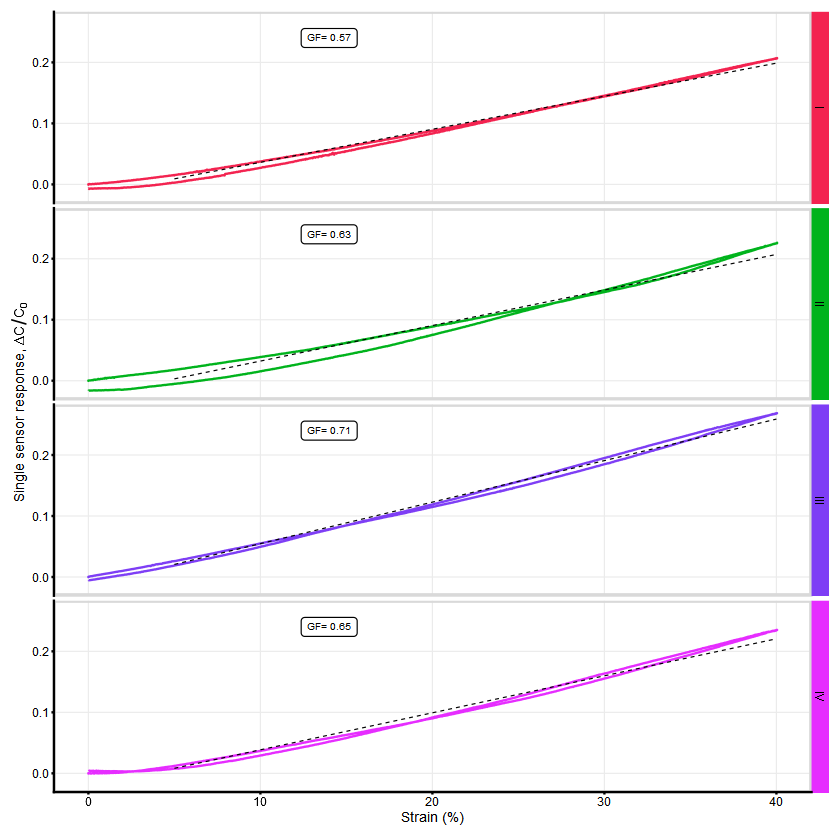

In [24]:
sensor_label_colours <- c('#F32350', '#00B31C', '#7E3EF5', '#E62DFF')
strip <- strip_themed(background_y = elem_list_rect(fill = sensor_label_colours))
# Change labels to roman numerals.
sensor_labeller <- as_labeller(c(
  'A'="I",
  'B'="II",
  'C'="III",
  'D'="IV"
))

plt1 <- ggplot(data=lcr, aes(x=strain, y=dCsC0, colour=sensor))
plt1 <- plt1 + geom_path(linewidth=0.5)
plt1 <- plt1 + geom_smooth(method="lm", xseq=seq(0.05, 0.4, length=100), fill=NA, colour="black", linewidth=0.25, linetype="dashed")
plt1 <- plt1 + scale_colour_manual(values=sensor_label_colours, guide="none")
plt1 <- plt1 + scale_x_continuous(labels=function(x)x*100)
plt1 <- plt1 + geom_label(data=gf, mapping=aes(label=paste('GF=', round(estimate, 2))), x=0.14, y=0.24, colour="black", size=2)
plt1 <- plt1 + ylab(expression('Single sensor response,'~Delta*C/C[0]))
plt1 <- plt1 + xlab(expression('Strain (%)'))
#plt1 <- plt1 + coord_equal()
plt1 <- plt1 + facet_grid2(vars(sensor), strip=strip, labeller=sensor_labeller)
plt1 <- plt1 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt1 <- plt1 + panel_border() + background_grid(major="xy", minor=NA, size.major=0.25)
plt1 <- plt1 + theme(panel.grid.major = element_line(colour="#EBEBEB", linewidth=0.25))
plt1 <- plt1 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt1)
ggsave('StressStrainABCD.png', width=25, height=50, units="mm", scale=1.5, dpi=600)
ggsave('StressStrainABCD.eps', width=25, height=50, units="mm", scale=1.5, device=cairo_ps, fallback_resolution=600)
save(plt1, file = "StressStrainABCD.rdata")

# Produce Figure from Sensor Board Data

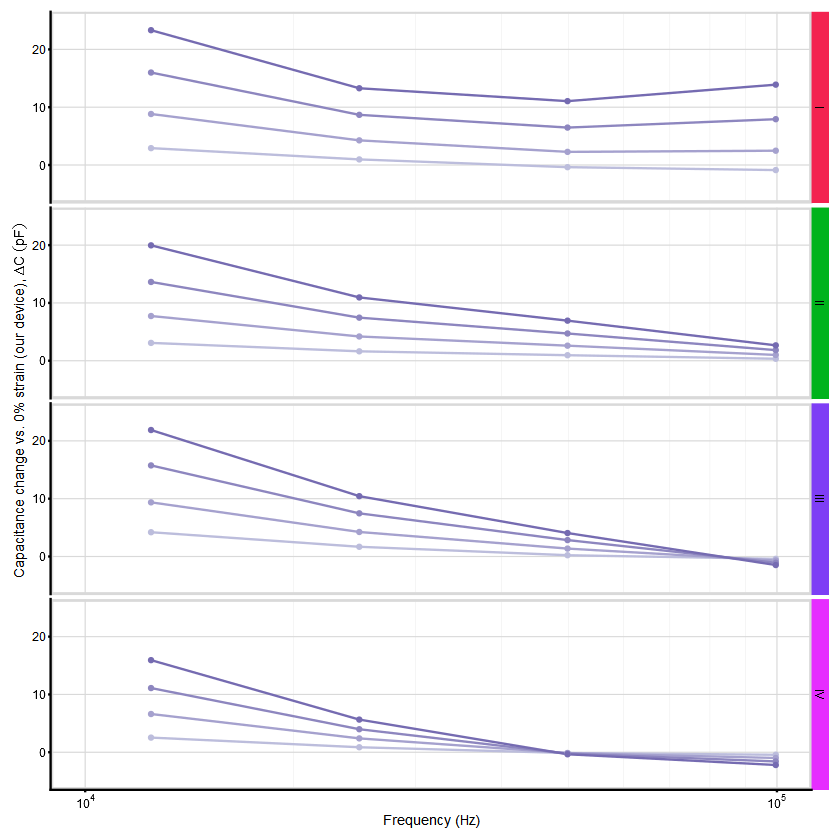

In [27]:
breaks <- 10^(3:6)
minor_breaks <- rep(1:9, length(breaks))*(10^rep((3:6), each=9))
strip <- strip_themed(background_y = elem_list_rect(fill = c('#F32350', '#00B31C', '#7E3EF5', '#E62DFF')))
# Change labels to roman numerals.
sensor_labeller <- as_labeller(c(
  'A'="I",
  'B'="II",
  'C'="III",
  'D'="IV"
))

plt5 <- ggplot(data=sensor_board, aes(x=f, y=dCp_mean*1e12, colour=strain, group=strain))
plt5 <- plt5 + scale_color_gradient(low='#bcbddc', high='#756bb1', labels=function(x)x*100, name="Strain (%)", guide="none")
plt5 <- plt5 + geom_line(linewidth=0.5)
plt5 <- plt5 + geom_point(size=0.75)
#plt5 <- plt5 + geom_errorbar(aes(ymin=(dCp_mean-dCp_sd)*1e12, ymax=(dCp_mean+dCp_sd)*1e12), width=0.05)
plt5 <- plt5 + scale_x_log10(limits=c(10^4, 10^5), breaks=breaks, minor_breaks=minor_breaks, labels=trans_format("log10", math_format(10^.x)))
plt5 <- plt5 + scale_y_continuous(minor_breaks=NULL, limits=c(-5,25), breaks=c(0, 10, 20))
plt5 <- plt5 + ylab(expression("Capacitance change vs. 0% strain (our device),"~Delta*C~(pF)))
plt5 <- plt5 + xlab('Frequency (Hz)')
plt5 <- plt5 + facet_grid2(vars(sensor), strip=strip, labeller=sensor_labeller)
plt5 <- plt5 + theme_cowplot(6) + theme(plot.margin = unit(c(0.25,0.25,0.25,0.25), "cm"))
plt5 <- plt5 + panel_border() + background_grid(major="xy", minor="xy", size.major=0.25, size.minor=0.1)
plt5 <- plt5 + theme(panel.grid.minor = element_line(colour="#EBEBEB"))
plt5 <- plt5 + theme(plot.background = element_rect(fill='white', colour='white'), text=element_text(size=8), axis.text.x = element_text(size = 7), axis.text.y = element_text(size = 7))

print(plt5)
ggsave('DeltaCSensorBoard.png', width=63, height=50, units="mm", scale=1.5, dpi=600)
ggsave("DeltaCSensorBoard.eps", width=63, height=50, units="mm", scale=1.5, device=cairo_ps, fallback_resolution=600)
save(plt5, file="DeltaCSensorBoardFigure.rdata")

## Compile Figure

Combine the plots and save as PNG, EPS.

In [28]:
#load("..\\2023-01-17_DistributeSensorTesting\\StressStrainABCD.rdata")
#load("..\\2023-01-31_DistributedSensorTesting_FreqSensorBoard1\\DeltaCSensorBoardFigure.rdata")
plots <- plot_grid(plt1, plt3, plt2, plt5, labels=c("a", "b", "c", "d"), rel_widths=c(1, 2.75, 2.75, 1.25), hjust=0.02, nrow=1)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 4000 rows containing missing values (`geom_vline()`)."
Warning message:
"Removed 4000 rows containing missing values (`geom_vline()`)."
Warning message:
"Removed 4000 rows containing missing values (`geom_vline()`)."
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
"Removed 4000 rows containing missing values (`geom_vline()`)."
Warning message:
"Removed 4000 rows containing missing values (`geom_vline()`)."
Warning message:
"Removed 4000 rows containing missing values (`geom_vline()`)."


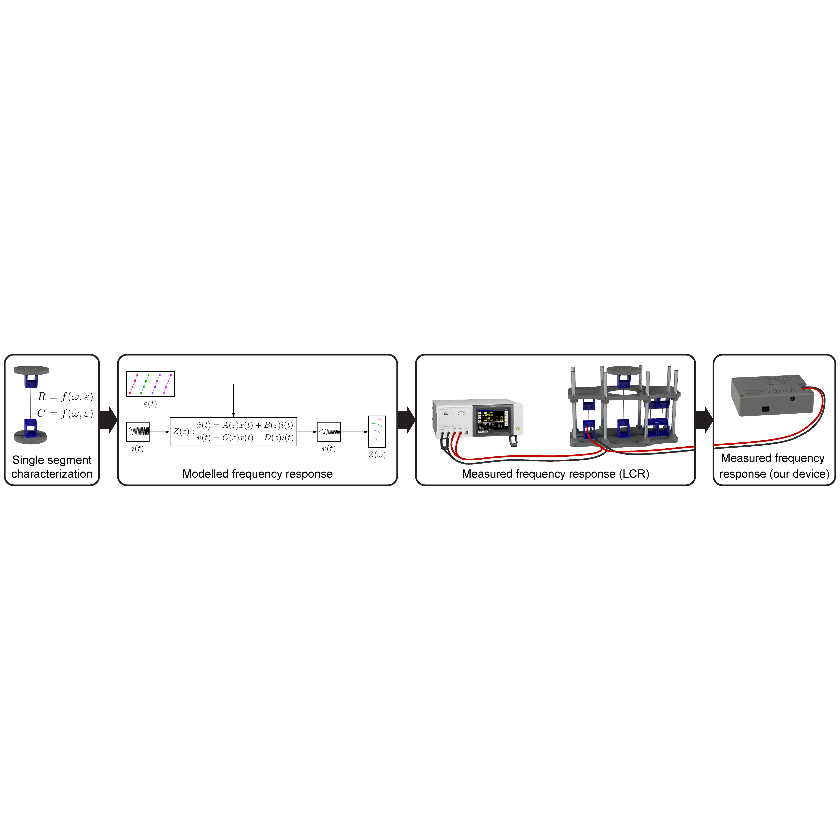

In [30]:
graphical_description <- ".\\Legend.png"
graphical_description <- ggdraw() + draw_image(graphical_description, scale=1)
graphical_description

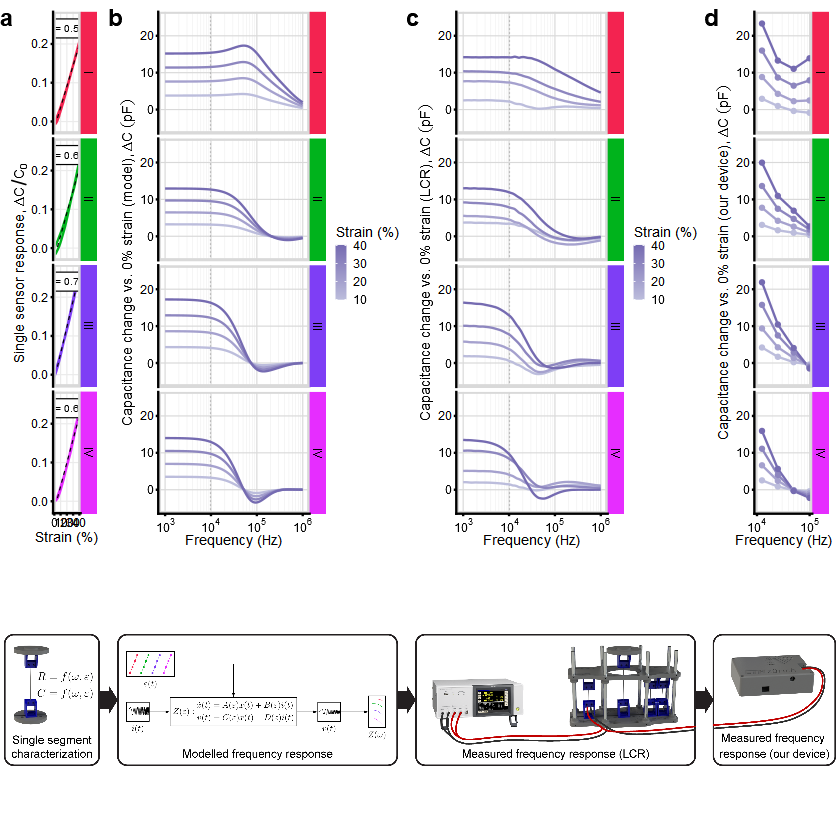

In [32]:
plot_grid(plots, graphical_description, rel_heights=c(60, 30), nrow=2)
ggsave('Fig4.png', width=180, height=90, units="mm", dpi=600, bg="white", scale=1.5)
ggsave("Fig4.eps", width=180, height=90, units="mm", scale=1.5, bg="white", device=cairo_ps, fallback_resolution=600)